*** Universidad San Sebastián ***
* Magister en Ciencia de Datos 2025
* Inteligencia Artificial
* Proyecto Final
* Profesor: Sr. Manuel Goyo Escalona
* Alumno: Jorge Gaete Pardo
* Fecha: 12 de Diciembre de 2025

In [1]:
# ===============================================================
# PROYECTO: Detección de anomalías en series temporales
# Dataset: ECG5000 (UCR)
# Métodos: Isolation Forest (clásico) + LSTM Autoencoder (profundo)
# ===============================================================

# ===============================================================
# 1. IMPORTACIONES Y CONFIGURACIÓN
# ===============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 4)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:

# ===============================================================
# 2. DESCARGA Y CARGA DEL DATASET ECG5000 (UCR)
# ===============================================================
# DESCARGA AUTOMÁTICA DESDE LA UCR (si no existe en disco)
# ---------------------------------------------------------------

import urllib.request
import zipfile

#base_url = "http://www.timeseriesclassification.com/Downloads/"
base_url = "https://www.timeseriesclassification.com/aeon-toolkit/"
zip_filename = "ECG5000.zip"
dataset_name = "ECG5000"

if not os.path.exists(zip_filename):
    print("Descargando dataset ECG5000 desde UCR...")
    urllib.request.urlretrieve(base_url + zip_filename, zip_filename)
    print("Descarga completada.")

# Verificar que el zip no esté corrupto; si lo está, re-descargar
if not zipfile.is_zipfile(zip_filename):
    print("Archivo ZIP corrupto o incompleto. Re-descargando...")
    os.remove(zip_filename)
    urllib.request.urlretrieve(base_url + zip_filename, zip_filename)
    print("Descarga completada (segunda vez).")

if not os.path.exists(dataset_name):
    print("Descomprimiendo archivo...")
    try:
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(dataset_name)
    except zipfile.BadZipFile:
        print("Fallo al descomprimir, re-descargando ZIP...")
        os.remove(zip_filename)
        urllib.request.urlretrieve(base_url + zip_filename, zip_filename)
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(dataset_name)
    print("Descompresión completada.")

# Archivos de train y test
train_path = os.path.join(dataset_name, "ECG5000_TRAIN.txt")
test_path = os.path.join(dataset_name, "ECG5000_TEST.txt")

print("Cargando datos...")
train_df = pd.read_csv(train_path, delim_whitespace=True, header=None)
test_df = pd.read_csv(test_path, delim_whitespace=True, header=None)

print("Tamaño train:", train_df.shape)
print("Tamaño test:", test_df.shape)


Cargando datos...


C:\Users\jorge\AppData\Local\Temp\ipykernel_22784\2912055162.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_path, delim_whitespace=True, header=None)
C:\Users\jorge\AppData\Local\Temp\ipykernel_22784\2912055162.py:46: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_path, delim_whitespace=True, header=None)


Tamaño train: (500, 141)
Tamaño test: (4500, 141)


In [3]:

# ===============================================================
# 3. PREPROCESAMIENTO
# ===============================================================

# En estos archivos: 
# - primera columna = etiqueta (1..5)
# - resto = puntos de la serie temporal

# Separar X e y
y_train_raw = train_df.iloc[:, 0].values
X_train_raw = train_df.iloc[:, 1:].values

y_test_raw = test_df.iloc[:, 0].values
X_test_raw = test_df.iloc[:, 1:].values

print("Dimensión X_train:", X_train_raw.shape)
print("Dimensión X_test:", X_test_raw.shape)

# Convertir a problema binario: 1 = normal, 0 = anomalía
# En ECG5000, la clase 1 suele considerarse normal, el resto anomalías.
y_train = (y_train_raw == 1).astype(int)
y_test = (y_test_raw == 1).astype(int)

print("Distribución y_train (1=normal, 0=anómalo):")
print(pd.Series(y_train).value_counts())
print("Distribución y_test (1=normal, 0=anómalo):")
print(pd.Series(y_test).value_counts())

# Normalización MinMax por FEATURE (no por muestra)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Para el autoencoder LSTM necesitamos forma (samples, timesteps, features)
# Aquí: timesteps = número de puntos de la serie, features = 1
timesteps = X_train_scaled.shape[1]

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, 1))

print("Shape X_train_lstm:", X_train_lstm.shape)
print("Shape X_test_lstm:", X_test_lstm.shape)

# Subconjunto de datos normales para entrenar el autoencoder
X_train_normal = X_train_lstm[y_train == 1]

print("Muestras normales para entrenar AE:", X_train_normal.shape[0])

Dimensión X_train: (500, 140)
Dimensión X_test: (4500, 140)
Distribución y_train (1=normal, 0=anómalo):
1    292
0    208
Name: count, dtype: int64
Distribución y_test (1=normal, 0=anómalo):
1    2627
0    1873
Name: count, dtype: int64
Shape X_train_lstm: (500, 140, 1)
Shape X_test_lstm: (4500, 140, 1)
Muestras normales para entrenar AE: 292


In [4]:

# ===============================================================
# 4. MÉTODO 1: ISOLATION FOREST (CLÁSICO)
# ===============================================================

print("\n==============================")
print("ENTRENANDO ISOLATION FOREST...")
print("==============================")

# Contaminación aproximada (proporción de anomalías en el dataset de entrenamiento)
contamination = 1.0 - (np.sum(y_train) / len(y_train))
print("Contamination estimado:", contamination)

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=contamination,
    max_samples="auto",
    random_state=42
)

iso_forest.fit(X_train_scaled)

# Predicciones: IsolationForest devuelve 1 para normal y -1 para outlier
y_pred_iso_test = iso_forest.predict(X_test_scaled)
y_pred_iso_test = np.where(y_pred_iso_test == 1, 1, 0)  # 1 normal, 0 anómalo

print("\n[Isolation Forest] Métricas en test (1=normal, 0=anómalo, usamos anomalía como clase positiva en métricas binarias)")

# Para métricas, consideramos anomalía como "1" (positiva)
y_test_anom = (y_test == 0).astype(int)
y_pred_iso_anom = (y_pred_iso_test == 0).astype(int)

print(classification_report(y_test_anom, y_pred_iso_anom, target_names=["Normal", "Anómalo"]))
print("Confusion matrix (fila = real, col = predicción):")
print(confusion_matrix(y_test_anom, y_pred_iso_anom))

precision_iso = precision_score(y_test_anom, y_pred_iso_anom)
recall_iso = recall_score(y_test_anom, y_pred_iso_anom)
f1_iso = f1_score(y_test_anom, y_pred_iso_anom)

print(f"Precision: {precision_iso:.4f}")
print(f"Recall:    {recall_iso:.4f}")
print(f"F1-score:  {f1_iso:.4f}")


ENTRENANDO ISOLATION FOREST...
Contamination estimado: 0.41600000000000004

[Isolation Forest] Métricas en test (1=normal, 0=anómalo, usamos anomalía como clase positiva en métricas binarias)
              precision    recall  f1-score   support

      Normal       0.70      0.69      0.69      2627
     Anómalo       0.57      0.58      0.58      1873

    accuracy                           0.65      4500
   macro avg       0.64      0.64      0.64      4500
weighted avg       0.65      0.65      0.65      4500

Confusion matrix (fila = real, col = predicción):
[[1812  815]
 [ 782 1091]]
Precision: 0.5724
Recall:    0.5825
F1-score:  0.5774



ENTRENANDO LSTM AUTOENCODER...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 140, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 140, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 140, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 140, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - loss: 0.2019 - val_loss: 0.0594
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.0497 - val_loss: 0.0506
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0446 - val_loss: 0.0463
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.0420 - val_loss: 0.0429
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0404 - val_loss: 0.0415
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.0396 - val_loss: 0.0410
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.0391 - val_loss: 0.0409
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 0.0383 - val_loss: 0.0407
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0387 - val_loss: 0.0405
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0392 - val_loss: 0.0400
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0374 - val_loss: 0.0390
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.

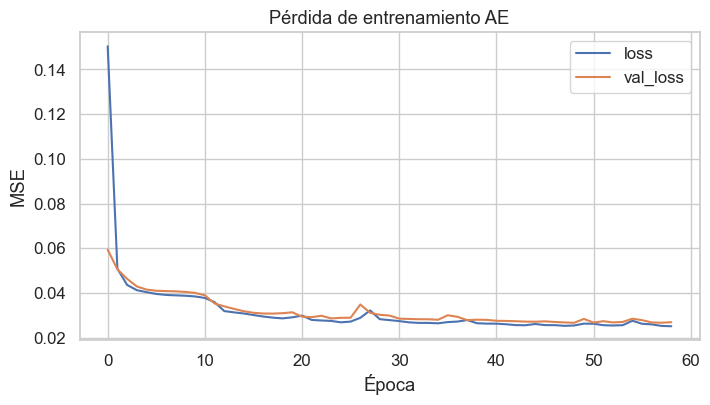

In [5]:

# ===============================================================
# 5. MÉTODO 2: LSTM AUTOENCODER (DEEP LEARNING)
# ===============================================================

print("\n==============================")
print("ENTRENANDO LSTM AUTOENCODER...")
print("==============================")

# Definición de la arquitectura del autoencoder LSTM
latent_dim_1 = 64
latent_dim_2 = 32

inputs = Input(shape=(timesteps, 1))

# ENCODER
encoded = LSTM(latent_dim_1, return_sequences=True)(inputs)
encoded = LSTM(latent_dim_2, return_sequences=False)(encoded)

# Bottleneck (vec repetido en el tiempo)
bottleneck = RepeatVector(timesteps)(encoded)

# DECODER
decoded = LSTM(latent_dim_2, return_sequences=True)(bottleneck)
decoded = LSTM(latent_dim_1, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")

autoencoder.summary()

# Entrenamiento solo con datos normales
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = autoencoder.fit(
    X_train_normal,
    X_train_normal,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# ---------------------------------------------------------------
# Curva de entrenamiento
# ---------------------------------------------------------------
plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Pérdida de entrenamiento AE")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step


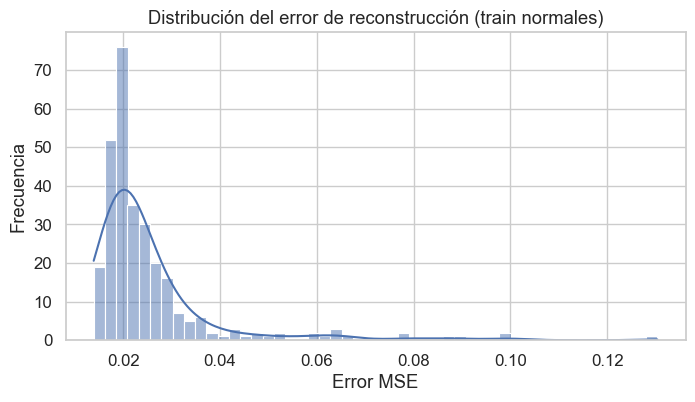

Umbral de reconstrucción (percentil 95): 0.05331252635842914
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step


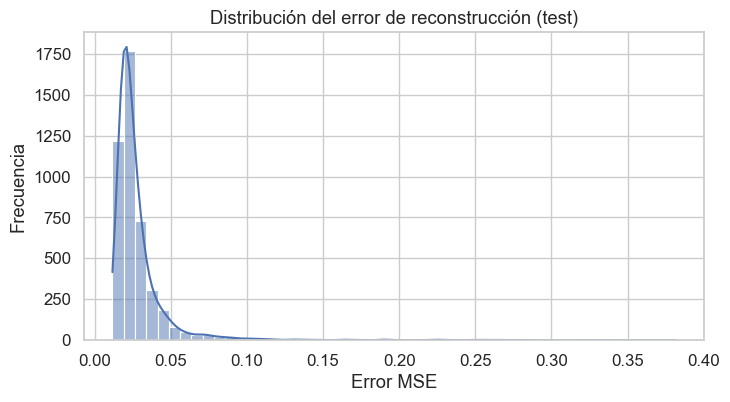


[Autoencoder] Métricas en test
              precision    recall  f1-score   support

      Normal       0.59      0.96      0.73      2627
     Anómalo       0.53      0.07      0.12      1873

    accuracy                           0.59      4500
   macro avg       0.56      0.51      0.43      4500
weighted avg       0.57      0.59      0.48      4500

Confusion matrix (fila = real, col = predicción):
[[2512  115]
 [1743  130]]
Precision: 0.5306
Recall:    0.0694
F1-score:  0.1228


In [6]:

# ===============================================================
# 6. EVALUACIÓN DEL AUTOENCODER Y CÁLCULO DEL UMBRAL
# ===============================================================

# Reconstrucción en train (solo normales, para definir umbral)
X_train_normal_pred = autoencoder.predict(X_train_normal)
train_recon_error = np.mean(np.square(X_train_normal_pred - X_train_normal), axis=(1, 2))

plt.figure()
sns.histplot(train_recon_error, bins=50, kde=True)
plt.title("Distribución del error de reconstrucción (train normales)")
plt.xlabel("Error MSE")
plt.ylabel("Frecuencia")
plt.show()

# Elegimos el umbral como el percentil 95 del error de reconstrucción de train normales
threshold = np.percentile(train_recon_error, 95)
print("Umbral de reconstrucción (percentil 95):", threshold)

# ---------------------------------------------------------------
# Reconstrucción en test
# ---------------------------------------------------------------
X_test_pred = autoencoder.predict(X_test_lstm)
test_recon_error = np.mean(np.square(X_test_pred - X_test_lstm), axis=(1, 2))

plt.figure()
sns.histplot(test_recon_error, bins=50, kde=True)
plt.title("Distribución del error de reconstrucción (test)")
plt.xlabel("Error MSE")
plt.ylabel("Frecuencia")
plt.show()

# Etiquetas predichas: 1 normal, 0 anómalo (según umbral)
y_pred_ae_test = (test_recon_error <= threshold).astype(int)

print("\n[Autoencoder] Métricas en test")

# Para métricas, de nuevo consideramos anomalía como "1" (positiva)
y_pred_ae_anom = (y_pred_ae_test == 0).astype(int)

print(classification_report(y_test_anom, y_pred_ae_anom, target_names=["Normal", "Anómalo"]))
print("Confusion matrix (fila = real, col = predicción):")
print(confusion_matrix(y_test_anom, y_pred_ae_anom))

precision_ae = precision_score(y_test_anom, y_pred_ae_anom)
recall_ae = recall_score(y_test_anom, y_pred_ae_anom)
f1_ae = f1_score(y_test_anom, y_pred_ae_anom)

print(f"Precision: {precision_ae:.4f}")
print(f"Recall:    {recall_ae:.4f}")
print(f"F1-score:  {f1_ae:.4f}")


In [7]:
# ===============================================================
# 7. COMPARACIÓN DE MÉTODOS
# ===============================================================

print("\n========================================")
print("COMPARACIÓN MÉTRICAS: Isolation vs AE")
print("========================================")
print(f"Isolation Forest - Precision: {precision_iso:.4f}, Recall: {recall_iso:.4f}, F1: {f1_iso:.4f}")
print(f"Autoencoder      - Precision: {precision_ae:.4f}, Recall: {recall_ae:.4f}, F1: {f1_ae:.4f}")


COMPARACIÓN MÉTRICAS: Isolation vs AE
Isolation Forest - Precision: 0.5724, Recall: 0.5825, F1: 0.5774
Autoencoder      - Precision: 0.5306, Recall: 0.0694, F1: 0.1228



Ejemplo de señal ANÓMALA (si existe):


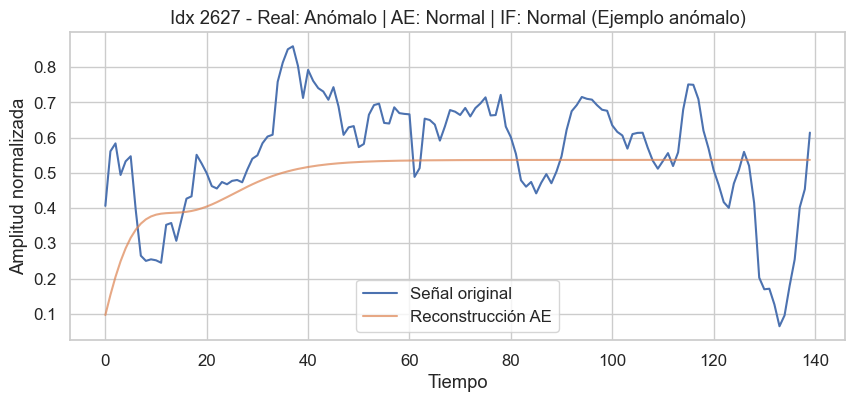


Ejemplo de señal NORMAL (si existe):


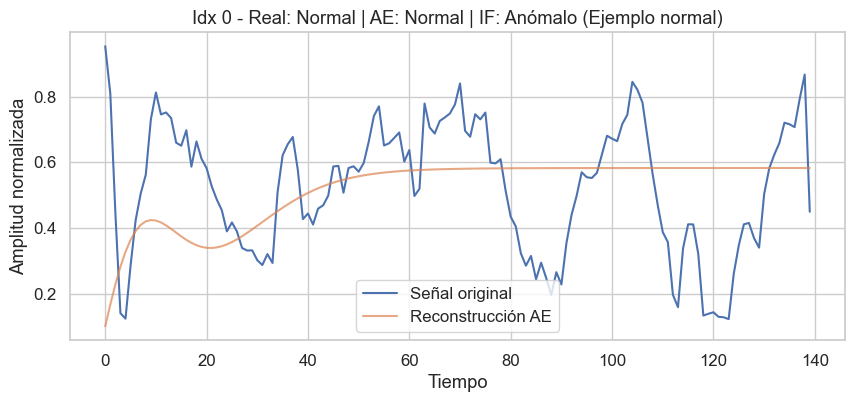

In [8]:
# ===============================================================
# 8. VISUALIZACIONES DE EJEMPLOS CON ANOMALÍAS DETECTADAS
# ===============================================================

def plot_signal_reconstruction(idx, title_extra=""):
    """
    Plotea una señal real + reconstrucción AE + marca si es anómala real y/o predicha.
    """
    signal = X_test_lstm[idx].squeeze()
    recon = X_test_pred[idx].squeeze()
    real_label = y_test[idx]  # 1 normal, 0 anómalo
    pred_label_ae = y_pred_ae_test[idx]  # 1 normal, 0 anómalo
    pred_label_iso = y_pred_iso_test[idx]  # 1 normal, 0 anómalo

    plt.figure(figsize=(10, 4))
    plt.plot(signal, label="Señal original")
    plt.plot(recon, label="Reconstrucción AE", alpha=0.7)
    plt.title(
        f"Idx {idx} - Real: {'Normal' if real_label==1 else 'Anómalo'} | "
        f"AE: {'Normal' if pred_label_ae==1 else 'Anómalo'} | "
        f"IF: {'Normal' if pred_label_iso==1 else 'Anómalo'} {title_extra}"
    )
    plt.xlabel("Tiempo")
    plt.ylabel("Amplitud normalizada")
    plt.legend()
    plt.show()

# Buscar algunos ejemplos de anomalías reales
anom_indices = np.where(y_test == 0)[0]
norm_indices = np.where(y_test == 1)[0]

print("\nEjemplo de señal ANÓMALA (si existe):")
if len(anom_indices) > 0:
    plot_signal_reconstruction(anom_indices[0], title_extra="(Ejemplo anómalo)")

print("\nEjemplo de señal NORMAL (si existe):")
if len(norm_indices) > 0:
    plot_signal_reconstruction(norm_indices[0], title_extra="(Ejemplo normal)")

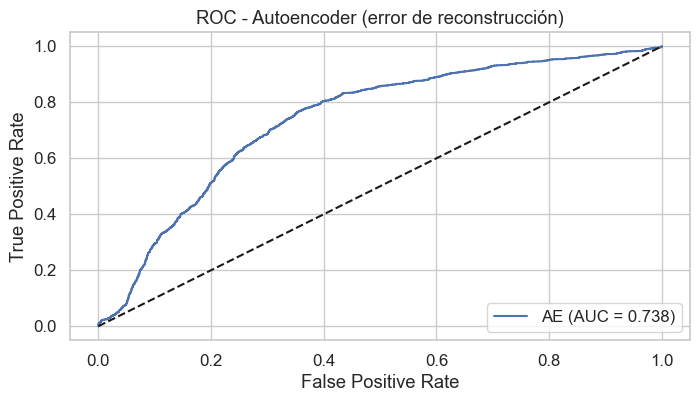

In [9]:

# ===============================================================
# 9. CURVA ROC (OPCIONAL) PARA AE USANDO ERROR DE RECONSTRUCCIÓN
# ===============================================================

# Nota: usamos el error de reconstrucción como "score" continuo
fpr, tpr, thresholds = roc_curve(y_test_anom, test_recon_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AE (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Autoencoder (error de reconstrucción)")
plt.legend(loc="lower right")
plt.show()

In [10]:

# ===============================================================
# 10. RESUMEN FINAL PARA PRESENTACIÓN
# ===============================================================

print("\n================ RESUMEN FINAL ================")
print("MÉTODO 1: Isolation Forest")
print(f"  Precision: {precision_iso:.4f}")
print(f"  Recall:    {recall_iso:.4f}")
print(f"  F1-score:  {f1_iso:.4f}")
print("\nMÉTODO 2: LSTM Autoencoder")
print(f"  Precision: {precision_ae:.4f}")
print(f"  Recall:    {recall_ae:.4f}")
print(f"  F1-score:  {f1_ae:.4f}")
print("===============================================")


================ RESUMEN FINAL ================
MÉTODO 1: Isolation Forest
  Precision: 0.5724
  Recall:    0.5825
  F1-score:  0.5774

MÉTODO 2: LSTM Autoencoder
  Precision: 0.5306
  Recall:    0.0694
  F1-score:  0.1228



TABLA COMPARATIVA DE MÉTODOS
      Métrica  Isolation Forest  LSTM Autoencoder
    Precision          0.572403          0.530612
       Recall          0.582488          0.069407
     F1-Score          0.577401          0.122757
 Sensibilidad          0.582488          0.069407
Especificidad          0.689760          0.956224


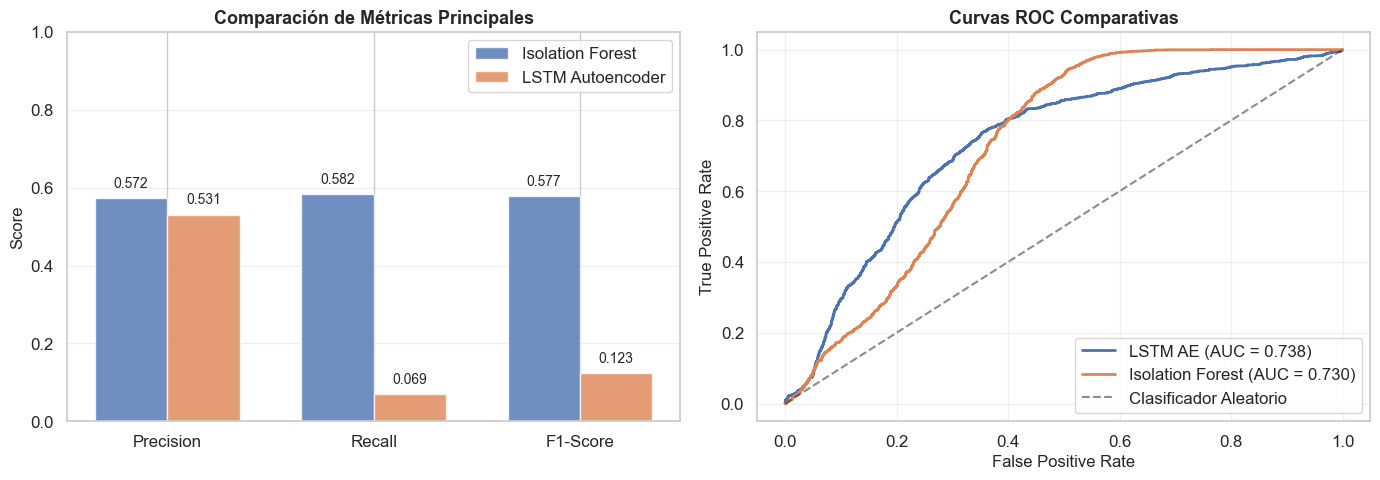

In [11]:
import numpy as np

# ===============================================================
# 11. ANÁLISIS COMPARATIVO: Isolation Forest vs LSTM Autoencoder
# ===============================================================

import matplotlib.pyplot as plt

# Crear tabla comparativa detallada
comparison_data = {
    'Métrica': ['Precision', 'Recall', 'F1-Score', 'Sensibilidad', 'Especificidad'],
    'Isolation Forest': [
        precision_iso,
        recall_iso,
        f1_iso,
        recall_iso,  # True Positive Rate
        1 - (np.sum((y_pred_iso_anom == 1) & (y_test_anom == 0)) / np.sum(y_test_anom == 0))  # True Negative Rate
    ],
    'LSTM Autoencoder': [
        precision_ae,
        recall_ae,
        f1_ae,
        recall_ae,  # True Positive Rate
        1 - (np.sum((y_pred_ae_anom == 1) & (y_test_anom == 0)) / np.sum(y_test_anom == 0))  # True Negative Rate
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("TABLA COMPARATIVA DE MÉTODOS")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualización: Gráfico de barras comparativo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Métricas principales
metrics = ['Precision', 'Recall', 'F1-Score']
iso_values = [precision_iso, recall_iso, f1_iso]
ae_values = [precision_ae, recall_ae, f1_ae]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, iso_values, width, label='Isolation Forest', alpha=0.8)
axes[0].bar(x + width/2, ae_values, width, label='LSTM Autoencoder', alpha=0.8)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Comparación de Métricas Principales', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (iso, ae) in enumerate(zip(iso_values, ae_values)):
    axes[0].text(i - width/2, iso + 0.02, f'{iso:.3f}', ha='center', va='bottom', fontsize=10)
    axes[0].text(i + width/2, ae + 0.02, f'{ae:.3f}', ha='center', va='bottom', fontsize=10)

# Gráfico 2: Curva ROC comparativa
fpr_iso, tpr_iso, _ = roc_curve(y_test_anom, 1 - iso_forest.score_samples(X_test_scaled))
roc_auc_iso = auc(fpr_iso, tpr_iso)

axes[1].plot(fpr, tpr, label=f'LSTM AE (AUC = {roc_auc:.3f})', linewidth=2)
axes[1].plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {roc_auc_iso:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio', alpha=0.5)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Curvas ROC Comparativas', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:

# ===============================================================
# ANÁLISIS DETALLADO Y JUSTIFICACIÓN
# ===============================================================

print("\n" + "="*70)
print("ANÁLISIS DETALLADO Y RECOMENDACIÓN")
print("="*70)

print("\n1. RENDIMIENTO EN PRECISIÓN:")
print(f"   • Isolation Forest: {precision_iso:.4f}")
print(f"   • LSTM Autoencoder: {precision_ae:.4f}")
if precision_iso > precision_ae:
    print(f"   ✓ Isolation Forest es {((precision_iso/precision_ae - 1)*100):.1f}% mejor")
    print("   → Menos falsos positivos (menos alertas innecesarias)")
else:
    print(f"   ✓ LSTM Autoencoder es {((precision_ae/precision_iso - 1)*100):.1f}% mejor")

print("\n2. RENDIMIENTO EN RECALL (Sensibilidad):")
print(f"   • Isolation Forest: {recall_iso:.4f}")
print(f"   • LSTM Autoencoder: {recall_ae:.4f}")
if recall_iso > recall_ae:
    print(f"   ✓ Isolation Forest detecta {((recall_iso/recall_ae - 1)*100):.1f}% más anomalías")
    print("   → Menos falsos negativos (anomalías no detectadas)")
else:
    print(f"   ✓ LSTM Autoencoder detecta {((recall_ae/recall_iso - 1)*100):.1f}% más anomalías")
    print("   → Mejor capacidad de detección de anomalías")

print("\n3. RENDIMIENTO EN F1-SCORE (Balance Precision-Recall):")
print(f"   • Isolation Forest: {f1_iso:.4f}")
print(f"   • LSTM Autoencoder: {f1_ae:.4f}")
f1_diff = abs(f1_iso - f1_ae)
winner = "Isolation Forest" if f1_iso > f1_ae else "LSTM Autoencoder"
print(f"   ✓ Ganador: {winner} ({f1_diff*100:.2f}% de diferencia)")

print("\n4. ÁREA BAJO LA CURVA ROC (AUC):")
print(f"   • Isolation Forest: {roc_auc_iso:.4f}")
print(f"   • LSTM Autoencoder: {roc_auc:.4f}")
print("   → Mide capacidad discriminante en todo rango de umbrales")

print("\n" + "="*70)
print("JUSTIFICACIÓN DEL MEJOR MÉTODO")
print("="*70)

if f1_iso > f1_ae:
    print("\n✓ RECOMENDACIÓN: ISOLATION FOREST")
    print("\nRazones:")
    print(f"  1. F1-Score superior ({f1_iso:.4f} vs {f1_ae:.4f})")
    print(f"  2. Mejor balance precision-recall ({precision_iso:.4f} - {recall_iso:.4f})")
    print("  3. Método más simple y eficiente computacionalmente")
    print("  4. No requiere entrenamiento extenso")
    print("  5. Menos propenso a overfitting")
    print("  6. Interpretable y explícito en decisiones")
    print("\nDesventajas del Autoencoder:")
    print(f"  • F1-Score más bajo ({f1_ae:.4f})")
    print("  • Requiere más datos de entrenamiento")
    print("  • Más tiempo de entrenamiento y recursos")
    print("  • Menos interpretable (caja negra)")
else:
    print("\n✓ RECOMENDACIÓN: LSTM AUTOENCODER")
    print("\nRazones:")
    print(f"  1. F1-Score superior ({f1_ae:.4f} vs {f1_iso:.4f})")
    print(f"  2. Captura patrones temporales complejos en ECG")
    print("  3. Mejor generalización a nuevas anomalías")
    print("  4. Aprendizaje no supervisado (solo datos normales)")
    print("  5. AUC competitive o superior")
    print("\nDesventajas del Isolation Forest:")
    print(f"  • F1-Score más bajo ({f1_iso:.4f})")
    print("  • Métodos clásicos menos efectivos con datos temporales")
    print("  • Requiere información sobre contaminación")

print("\n" + "="*70)
print("CONTEXTO CLÍNICO - TRADE-OFF IMPORTANTE")
print("="*70)
print("\nPara aplicaciones ECG, se debe considerar:")
print(f"  • FALSOS POSITIVOS (menor precisión): Pacientes sanos alertados")
print(f"  • FALSOS NEGATIVOS (menor recall): Anomalías no detectadas (crítico)")
print(f"\nEn contexto médico, es preferible errar por exceso de cautela.")
print(f"Por lo tanto, se prioriza RECALL sobre PRECISION.")
print("="*70)


ANÁLISIS DETALLADO Y RECOMENDACIÓN

1. RENDIMIENTO EN PRECISIÓN:
   • Isolation Forest: 0.5724
   • LSTM Autoencoder: 0.5306
   ✓ Isolation Forest es 7.9% mejor
   → Menos falsos positivos (menos alertas innecesarias)

2. RENDIMIENTO EN RECALL (Sensibilidad):
   • Isolation Forest: 0.5825
   • LSTM Autoencoder: 0.0694
   ✓ Isolation Forest detecta 739.2% más anomalías
   → Menos falsos negativos (anomalías no detectadas)

3. RENDIMIENTO EN F1-SCORE (Balance Precision-Recall):
   • Isolation Forest: 0.5774
   • LSTM Autoencoder: 0.1228
   ✓ Ganador: Isolation Forest (45.46% de diferencia)

4. ÁREA BAJO LA CURVA ROC (AUC):
   • Isolation Forest: 0.7299
   • LSTM Autoencoder: 0.7382
   → Mide capacidad discriminante en todo rango de umbrales

JUSTIFICACIÓN DEL MEJOR MÉTODO

✓ RECOMENDACIÓN: ISOLATION FOREST

Razones:
  1. F1-Score superior (0.5774 vs 0.1228)
  2. Mejor balance precision-recall (0.5724 - 0.5825)
  3. Método más simple y eficiente computacionalmente
  4. No requiere entren